In [1]:
import sys

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as display

sys.path.append('../src')
import const
from metrics import row_wise_micro_averaged_f1_score, micro_f1_similarity

pd.options.display.max_rows=120

In [2]:
def fill_dropped(dropped_array, drop_idx):
    filled_array = np.zeros(
        (len(dropped_array) + len(drop_idx), dropped_array.shape[1])
    )
    idx_array = np.arange(len(filled_array))
    use_idx = np.delete(idx_array, drop_idx)
    filled_array[use_idx, :] = dropped_array
    return filled_array

In [3]:
def extract_label(preds, th=0.5):
    events = preds >= th
    nocall_col = np.zeros((len(preds), 1)).astype(bool)
    nocall_col[events.sum(1) == 0] = True
    events = np.concatenate([events, nocall_col], axis=1)
    
    predict_labels = []
    for i in range(len(events)):
        event = events[i, :]
        labels = np.argwhere(event).reshape(-1).tolist()
        
        row_labels = []
        for label in labels:
            row_labels.append(const.INV_BIRD_CODE[label])
        predict_labels.append(" ".join(row_labels))

    return predict_labels

In [4]:
def plot_oof(idx, th=0.27):
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.plot(oof[idx, :])
    plt.plot([0, 397], [th, th], "--", c="orange", alpha=0.3)
    
    top5_bc = np.argsort(oof[idx, :])[-5:]
    
    for bc in range(len(oof[idx, :])):
        if bc in top5_bc:
            plt.text(bc, oof[idx, bc] - oof[idx, :].max() * 0.05, s=const.INV_BIRD_CODE[bc])
    plt.ylim([0, 1.0])

    
    plt.subplot(2, 1, 2)
    plt.plot(post_oof[idx, :])
    plt.plot([0, 397], [th, th], "--", c="orange", alpha=0.3)

    for bc in range(len(post_oof[idx, :])):
        if bc in top5_bc:
            plt.text(bc, post_oof[idx, bc] - post_oof[idx, :].max() * 0.05, s=const.INV_BIRD_CODE[bc])
    plt.ylim([0, 1.0])
    
    
def plot_oof_mean(df):
    idx = df.index.values
    mean_ = oof[idx, :].mean(0) 
    quantile = np.quantile(mean_, 0.99)
    
    post_mean_ = post_oof[idx, :].mean(0)
    post_quantile = np.quantile(post_mean_, 0.99)

    plt.figure(figsize=(16, 5))
    plt.subplot(2, 1, 1)
    plt.plot(mean_)
    plt.plot([0, 397], [quantile, quantile], "--", c="orange", alpha=0.3)

    top5_bc = np.argsort(mean_)[-5:]
    top5_birds = []
    for bc in range(len(mean_)):
        if bc in top5_bc:
            plt.text(bc, mean_[bc] - mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
            top5_birds.append(const.INV_BIRD_CODE[bc])
            
    plt.subplot(2, 1, 2)
    plt.plot(post_mean_)
    plt.plot([0, 397], [post_quantile, post_quantile], "--", c="orange", alpha=0.3)

    top5_bc = np.argsort(post_mean_)[-5:]
    top5_birds = []
    for bc in range(len(post_mean_)):
        if bc in top5_bc:
            plt.text(bc, post_mean_[bc] - post_mean_.max() * 0.05, s=const.INV_BIRD_CODE[bc])
            top5_birds.append(const.INV_BIRD_CODE[bc])

    plt.show()

In [5]:
valid_df = pd.read_csv('../data/input/train_soundscape_labels.csv')
use_idx = valid_df[~valid_df["audio_id"].isin([7019, 7954, 14473])].index
drop_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473])].index
valid_df = valid_df.iloc[use_idx].reset_index(drop=True)

val_y_labels = valid_df["birds"].tolist()

In [6]:
oof163 = np.load("../logs/exp_163_20210529161018_0.648/oof.npy")
oof163 = fill_dropped(oof163, drop_idx)
oof164 = np.load("../logs/exp_164_20210529204320_0.654/oof.npy")
oof164 = fill_dropped(oof164, drop_idx)
oof165 = np.load("../logs/exp_165_20210530010704_0.654/oof.npy")
oof165 = fill_dropped(oof165, drop_idx)
oof166 = np.load("../logs/exp_166_20210530055519_0.659/oof.npy")
oof166 = fill_dropped(oof166, drop_idx)
oof167 = np.load("../logs/exp_167_20210529114938_0.638/oof.npy")
oof167 = fill_dropped(oof167, drop_idx)
oof168 = np.load("../logs/exp_168_20210529115009_0.645/oof.npy")
oof168 = fill_dropped(oof168, drop_idx)
oof169 = np.load("../logs/exp_169_20210529115052_0.658/oof.npy")
oof169 = fill_dropped(oof169, drop_idx)
oof170 = np.load("../logs/exp_170_20210529115126_0.660/oof.npy")
oof170 = fill_dropped(oof170, drop_idx)
oof171 = np.load("../logs/exp_171_20210530010436_0.634/oof.npy")
oof171 = fill_dropped(oof171, drop_idx)
oof172 = np.load("../logs/exp_172_20210530010440_0.644/oof.npy")
oof172 = fill_dropped(oof172, drop_idx)
oof173 = np.load("../logs/exp_173_20210530010446_0.637/oof.npy")
oof173 = fill_dropped(oof173, drop_idx)
oof174 = np.load("../logs/exp_174_20210530010451_0.647/oof.npy")
oof174 = fill_dropped(oof174, drop_idx)
oof175 = np.load("../logs/exp_175_20210530105944_0.666/oof.npy")
oof175 = fill_dropped(oof175, drop_idx)

# nocall classification
oof59 = np.load("../logs/exp_059_20210505100513_0.666/oof.npy")
oof70 = np.load("../logs/exp_070_20210508193023_0.882/oof.npy")
oof79 = np.load("../logs/exp_079_20210511132329_0.874/oof.npy")
oof83 = np.load("../logs/exp_083_20210512081958_0.827/oof.npy")
oof99 = np.load("../logs/exp_099_20210515202257_0.859/oof.npy")

In [7]:
oof_list = [
    oof163,
    oof164,
    oof165,
    oof166,
    oof167,
    oof168,
    oof169,
    oof170,
    oof171,
#     oof172,
#     oof173,
    oof174,
]

concat_oof = []
for oof_ in oof_list:
    concat_oof.append(oof_[np.newaxis, :, :])
concat_oof = np.concatenate(concat_oof)

In [8]:
oof = np.mean(concat_oof, axis=0)[use_idx, :]
oof_labels = extract_label(oof, th=0.27)

In [9]:
score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
score

0.7239869281045727

In [10]:
def post_process_v2_plus(preds, df, c=2, q=0.99, w=1.5, min_th=0.1, max_th=0.2):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if (np.argmax(post_preds[idx, :]) == bc and np.max(post_preds[idx, :]) >= 0.1) or post_preds[idx, bc] >= max_th:
                        post_preds[idx, bc] *= w
            else:
                break

    return post_preds


def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v10(preds, pred_labels, df, window_size=1, c=2.0, min_th=0.1, max_th=0.5):
    first_labels = []
    for idx in df.index:
        row_prob = preds[idx, :]
        second_prob = np.sort(row_prob)[-2]

        first_label_bc = np.argmax(row_prob)
        v = row_prob[first_label_bc]
        if (v >= (second_prob * c) and v >= min_th) or v >= max_th:
            first_labels.append(const.INV_BIRD_CODE[first_label_bc])
        else:
            first_labels.append("nocall")

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(first_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list


def post_process_v14(post_labels, avg_labels, df):
    final_labels = post_labels.copy()
    
    gp = df.groupby("audio_id")
    
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        
        multi_label_counter = 0
        multi_label_idxs = []
        for idx in idxs:
            if len(avg_labels[idx].split(" ")) >= 2:
                multi_label_idxs.append(idx)
                multi_label_counter += 1
                
        if multi_label_counter >= 10:
            for ml_idx in multi_label_idxs:
                row_post_labels = post_labels[ml_idx].split(" ")
                row_avg_labels = avg_labels[ml_idx].split(" ")

                if len(row_post_labels) == 1 and  (row_post_labels[0] in row_avg_labels or row_post_labels[0] == "nocall"):
                    final_labels[ml_idx] = avg_labels[ml_idx]
            
    return final_labels


def post_process_v15(preds, max_sample=30, c=2.0, q=0.99, p=0.3):
    post_preds = preds.copy()

    for bc in range(preds.shape[1]):
        bird = const.INV_BIRD_CODE[bc]
        sample_num = const.BIRD_SAMPLE_NUM[bird]
        
        if sample_num <= max_sample:
            prob = preds[:, bc]
            quantile = np.quantile(prob, q) * c

            post_preds[:, bc] = np.where(prob >= quantile, p, prob)
    
    return post_preds

In [11]:
post_oof = post_process_v15(oof, max_sample=30, c=2.0, q=0.99, p=0.3)
post_oof = post_process_v2_plus(post_oof, valid_df, c=2.5, q=0.99, w=2.0, min_th=0.10, max_th=0.20)
oof_labels_ = extract_label(post_oof, th=0.61)
post_oof_labels= post_process_v10(post_oof, oof_labels_, valid_df, window_size=5, c=1.2, min_th=0.15, max_th=0.4)
post_post_oof_labels = post_process_v14(post_oof_labels, oof_labels, valid_df)

In [12]:
score = row_wise_micro_averaged_f1_score(val_y_labels, post_oof_labels)
score

0.7661111111111084

In [13]:
valid_df["oof_birds"] = oof_labels
valid_df["post_raw_birds"] = oof_labels_
valid_df["post_oof_birds"] = post_oof_labels
valid_df["post_post_oof_birds"] = post_post_oof_labels

oof_argsort_array = np.argsort(oof, axis=1)[:, ::-1]

valid_df["first_label"] = oof_argsort_array[:, 0]
valid_df["second_label"] = oof_argsort_array[:, 1]
valid_df["third_label"] = oof_argsort_array[:, 2]

valid_df["first_label"] = valid_df["first_label"].apply(lambda x: const.INV_BIRD_CODE[x])
valid_df["second_label"] = valid_df["second_label"].apply(lambda x: const.INV_BIRD_CODE[x])
valid_df["third_label"] = valid_df["third_label"].apply(lambda x: const.INV_BIRD_CODE[x])

In [14]:
for col in ["oof_birds", "post_oof_birds", "post_post_oof_birds"]:
    score = row_wise_micro_averaged_f1_score(valid_df["birds"].tolist(), valid_df[col].tolist())
    print(f"{col}: {score:.4f}")

oof_birds: 0.7240
post_oof_birds: 0.7661
post_post_oof_birds: 0.7668


In [15]:
valid_df["nocall_birds"] = 0
valid_df.loc[valid_df[valid_df["birds"] == "nocall"].index, "nocall_birds"] = 1

valid_df["nocall_oof_birds"] = 0
valid_df.loc[valid_df[valid_df["oof_birds"] == "nocall"].index, "nocall_oof_birds"] = 1

In [16]:
f1_array = np.zeros(len(valid_df))
for idx in valid_df.index:
    b = valid_df.loc[idx, "birds"]
    ob = valid_df.loc[idx, "oof_birds"]
    f1_array[idx] = micro_f1_similarity(b, ob)

post_f1_array = np.zeros(len(valid_df))
for idx in valid_df.index:
    b = valid_df.loc[idx, "birds"]
    pb = valid_df.loc[idx, "post_oof_birds"]
    post_f1_array[idx] = micro_f1_similarity(b, pb)
    
post_post_f1_array = np.zeros(len(valid_df))
for idx in valid_df.index:
    b = valid_df.loc[idx, "birds"]
    ppb = valid_df.loc[idx, "post_post_oof_birds"]
    post_post_f1_array[idx] = micro_f1_similarity(b, ppb)

valid_df["f1"] = f1_array
valid_df["post_f1"] = post_f1_array
valid_df["post_post_f1"] = post_post_f1_array
valid_df.head()

row_id site  audio_id  seconds    birds oof_birds post_raw_birds  \
0   11254_COR_5  COR     11254        5  rubwre1   wbwwre1         nocall   
1  11254_COR_10  COR     11254       10   nocall   wbwwre1        wbwwre1   
2  11254_COR_15  COR     11254       15  rubwre1   wbwwre1         nocall   
3  11254_COR_20  COR     11254       20   nocall    nocall         nocall   
4  11254_COR_25  COR     11254       25  rubwre1   rubwre1        rubwre1   

  post_oof_birds post_post_oof_birds first_label second_label third_label  \
0        wbwwre1             wbwwre1     wbwwre1      rubwre1     burwar1   
1        wbwwre1             wbwwre1     wbwwre1      rubwre1     goftyr1   
2        wbwwre1             wbwwre1     wbwwre1      rubwre1     baywre1   
3         nocall              nocall     monoro1       fepowl     creoro1   
4        rubwre1             rubwre1     rubwre1      wbwwre1     baywre1   

   nocall_birds  nocall_oof_birds   f1  post_f1  post_post_f1  
0             0                 0  0.0      0.0           0.0  
1             1                 0  0.0      0.0           0.0  
2             0                 0  0.0      0.0           0.0  
3             1                 1  1.0      1.0           1.0  
4             0                 0  1.0      1.0           1.0

In [17]:
valid_df[valid_df["f1"] < 1]

row_id site  audio_id  seconds    birds oof_birds post_raw_birds  \
0       11254_COR_5  COR     11254        5  rubwre1   wbwwre1         nocall   
1      11254_COR_10  COR     11254       10   nocall   wbwwre1        wbwwre1   
2      11254_COR_15  COR     11254       15  rubwre1   wbwwre1         nocall   
38    11254_COR_195  COR     11254      195   nocall    yebfly         yebfly   
42    11254_COR_215  COR     11254      215   brnjay    nocall         nocall   
...             ...  ...       ...      ...      ...       ...            ...   
2028  54955_SSW_545  SSW     54955      545   chswar    nocall         nocall   
2030  54955_SSW_555  SSW     54955      555   chswar    nocall         nocall   
2031  54955_SSW_560  SSW     54955      560   grycat    nocall         nocall   
2036  54955_SSW_585  SSW     54955      585   grycat    nocall         nocall   
2038  54955_SSW_595  SSW     54955      595   nocall    grycat         nocall   

     post_oof_birds post_post_oof_birds first_label second_label third_label  \
0           wbwwre1             wbwwre1     wbwwre1      rubwre1     burwar1   
1           wbwwre1             wbwwre1     wbwwre1      rubwre1     goftyr1   
2           wbwwre1             wbwwre1     wbwwre1      rubwre1     baywre1   
38           yebfly              yebfly      yebfly       acafly     reevir1   
42           yebfly              yebfly      yebfly      strcuc1      acafly   
...             ...                 ...         ...          ...         ...   
2028         chswar              chswar      chswar       warvir      lazbun   
2030         nocall              nocall      canwar       ducfly      whtspa   
2031         nocall              nocall      grycat       blujay      warvir   
2036         nocall              nocall      canwar       whtspa      naswar   
2038         nocall              nocall      grycat       warvir      chswar   

      nocall_birds  nocall_oof_birds   f1  post_f1  post_post_f1  
0                0                 0  0.0      0.0           0.0  
1                1                 0  0.0      0.0           0.0  
2                0                 0  0.0      0.0           0.0  
38               1                 0  0.0      0.0           0.0  
42               0                 1  0.0      0.0           0.0  
...            ...               ...  ...      ...           ...  
2028             0                 1  0.0      1.0           1.0  
2030             0                 1  0.0      0.0           0.0  
2031             0                 1  0.0      0.0           0.0  
2036             0                 1  0.0      0.0           0.0  
2038             1                 0  0.0      1.0           1.0  

[648 rows x 17 columns]

In [18]:
gp = valid_df.groupby("audio_id")

corr_array = np.zeros(len(oof))
for audio_id, audio_df in gp:
    idxs = audio_df.index.values
    
    for i, idx in enumerate(idxs):
        if i == 0:
            pass
        else:
            corr = np.corrcoef(oof[idx - 1, :], oof[idx, :])[0, 1]
            corr_array[idx] = corr
            
valid_df["corr"] = corr_array

In [19]:
# usecols = ["row_id", "seconds", "birds", "oof_birds", "post_oof_birds", "first_label", "second_label", "third_label", "birdcall_p"]
# usecols = ["row_id", "seconds", "birds", "oof_birds", "post_raw_birds", "post_oof_birds", "first_label", "second_label", "birdcall_p", "corr", "f1"]
usecols = ["row_id", "seconds", "birds", "oof_birds", "f1", "post_oof_birds", "post_f1", "post_post_oof_birds", "post_post_f1", "corr"]

In [20]:
for audio_id, audio_df in gp:
    idxs = audio_df.index.values
    score = row_wise_micro_averaged_f1_score( valid_df.loc[idxs, "birds"].values, valid_df.loc[idxs, "oof_birds"])

    print(f"audio_id: {audio_id}\n score: {score:.4f}")
    print("-" * 50)
    print(audio_df['birds'].value_counts())
    print("\n")
    print(audio_df['oof_birds'].value_counts())
    print("\n")

audio_id: 2782
 score: 0.5019
--------------------------------------------------
eawpew reevir1                  37
reevir1                         23
bkcchi eawpew reevir1           20
eawpew grycat reevir1           16
grycat reevir1                   9
bkcchi reevir1                   8
bkcchi eawpew grycat reevir1     3
bkcchi grycat reevir1            2
chswar eawpew reevir1            1
chswar eawpew grycat reevir1     1
Name: birds, dtype: int64


reevir1           36
nocall            35
eawpew            15
eawpew reevir1    15
grycat            14
grycat obnthr1     2
acafly             1
bkcchi             1
obnthr1            1
Name: oof_birds, dtype: int64


audio_id: 7843
 score: 0.9833
--------------------------------------------------
nocall    116
blujay      2
bkcchi      2
Name: birds, dtype: int64


nocall    118
blujay      2
Name: oof_birds, dtype: int64


audio_id: 10534
 score: 0.6389
--------------------------------------------------
nocall            63
rewbla

## audio_id: 2782

In [21]:
idx = valid_df[valid_df["audio_id"] == 2782].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

In [22]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

48

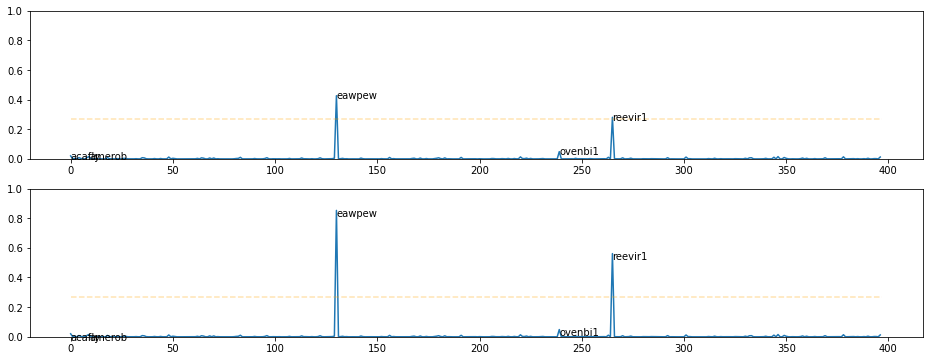

In [23]:
plot_oof(973)

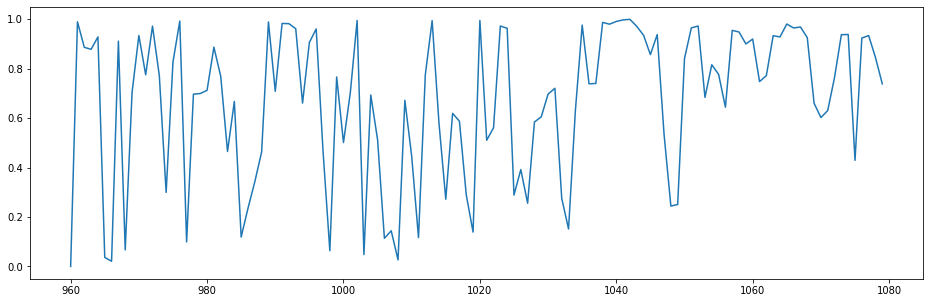

In [24]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [25]:
np.corrcoef(oof[1055, :], oof[1056, :])[0, 1]

0.6439752738737283

In [26]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.5019444444444446

In [27]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.6036111111111108

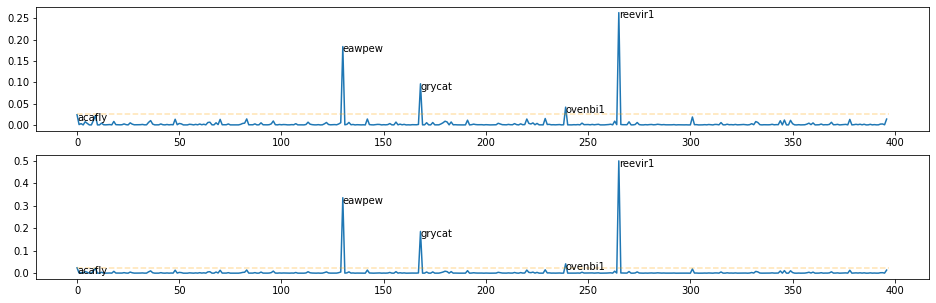

In [28]:
plot_oof_mean(df)

## audio_id: 7843

In [29]:
idx = valid_df[valid_df["audio_id"] == 7843].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

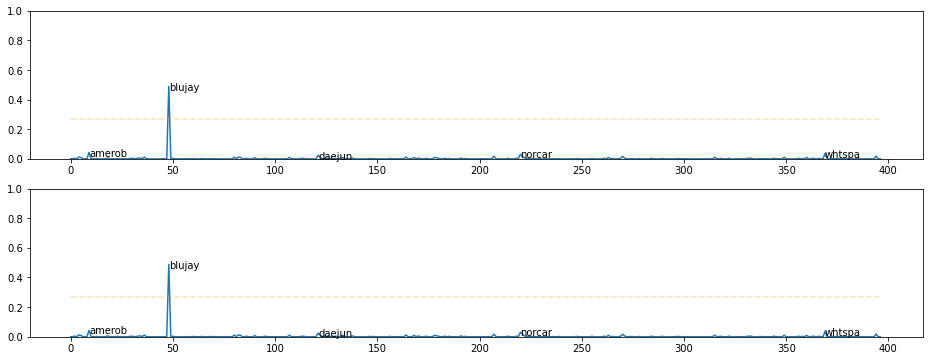

In [30]:
plot_oof(1185)

In [31]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

2

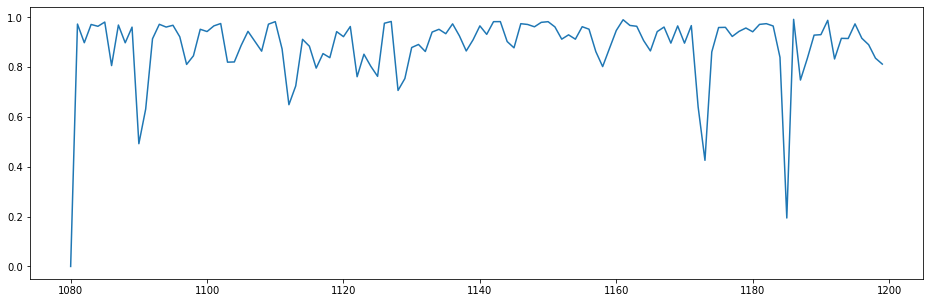

In [32]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [33]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.9833333333333323

In [34]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.016666666666666666

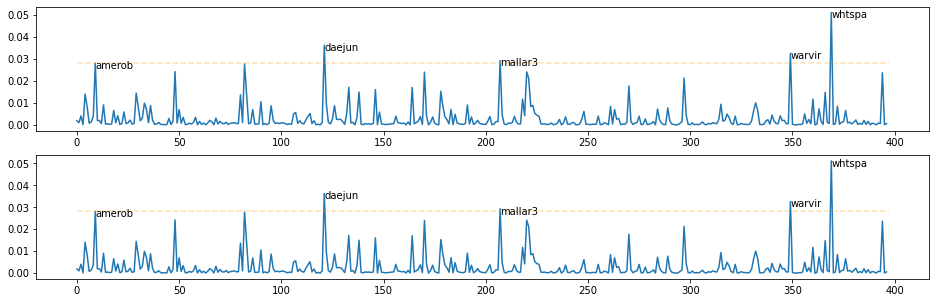

In [35]:
plot_oof_mean(df)

## audio_id: 10534

In [36]:
idx = valid_df[valid_df["audio_id"] == 10534].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

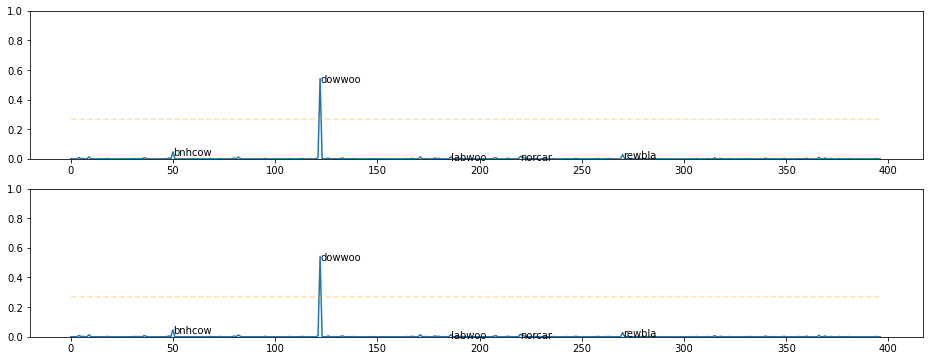

In [37]:
plot_oof(1288)

In [38]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

31

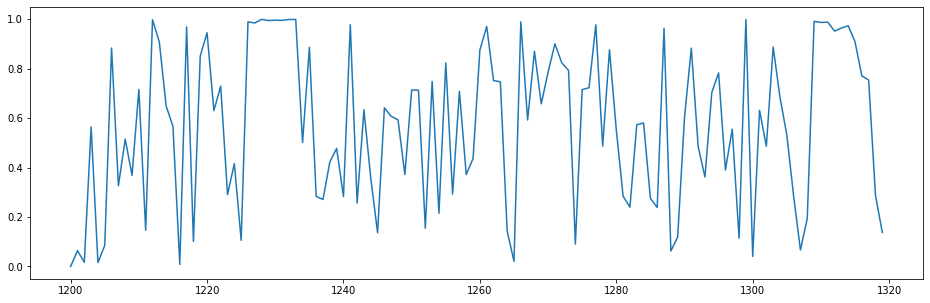

In [39]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [40]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.6388888888888891

In [41]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.37500000000000033

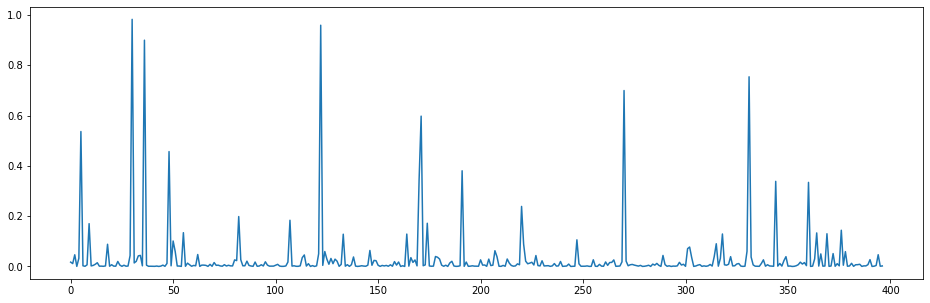

In [42]:
plt.figure(figsize=(16, 5))
plt.plot(oof[1200: 1320].max(0))

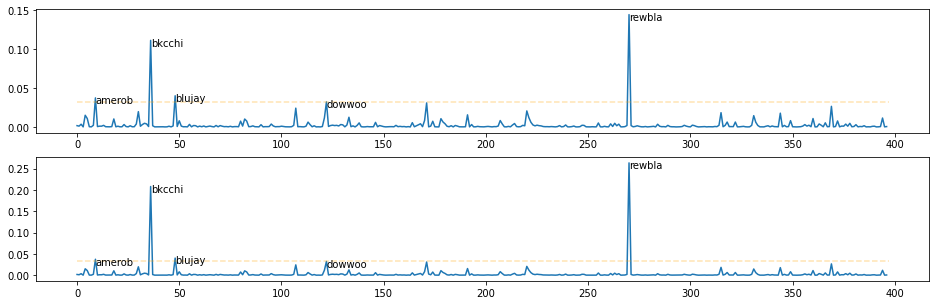

In [43]:
plot_oof_mean(df)

## audio_id: 11254

In [44]:
idx = valid_df[valid_df["audio_id"] == 11254].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

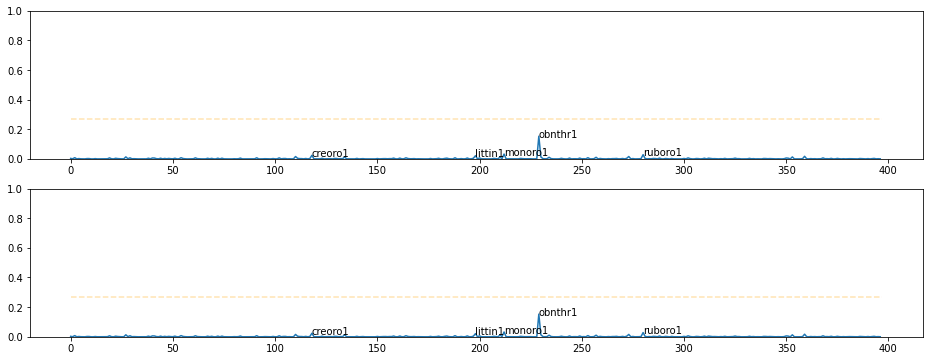

In [45]:
plot_oof(26)

In [46]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

8

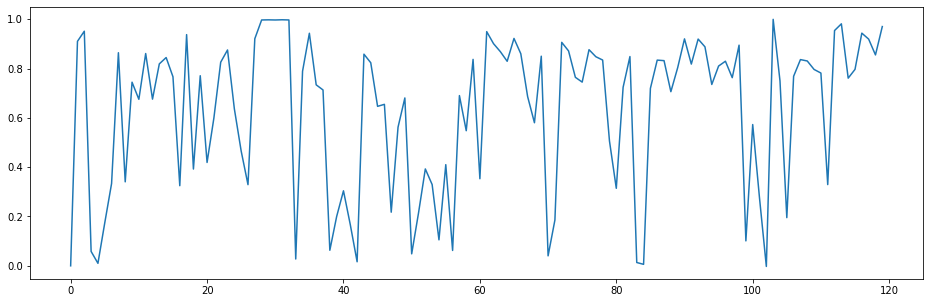

In [47]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [48]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.8749999999999993

In [49]:
len(df[df["birds"] == "nocall"])

105

In [50]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.08888888888888888

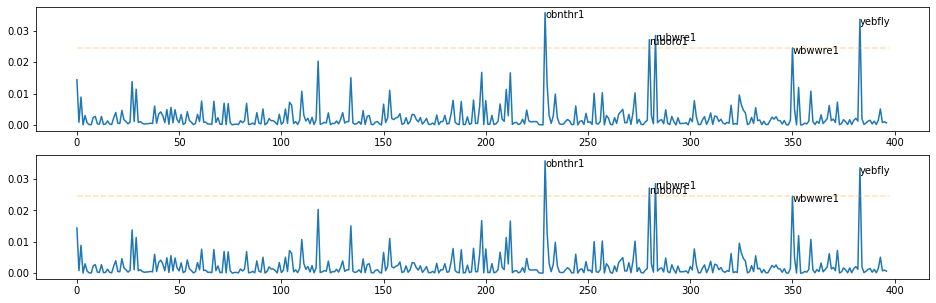

In [51]:
plot_oof_mean(df)

## audio_id: 18003

In [52]:
idx = valid_df[valid_df["audio_id"] == 18003].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

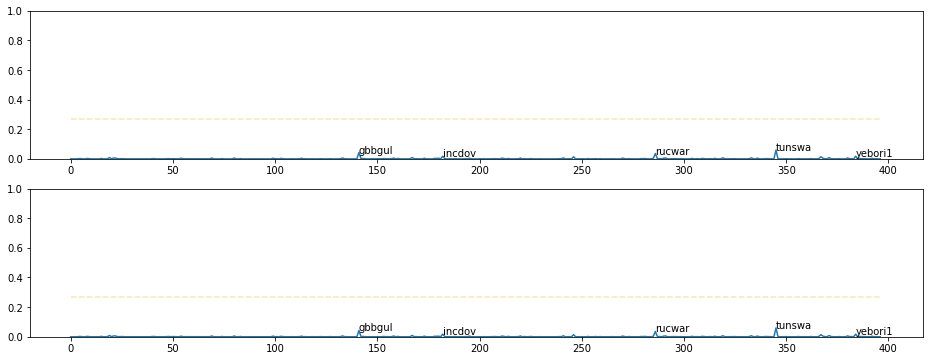

In [53]:
plot_oof(237)

In [54]:
(df["oof_birds"] != df["post_oof_birds"]).sum()

18

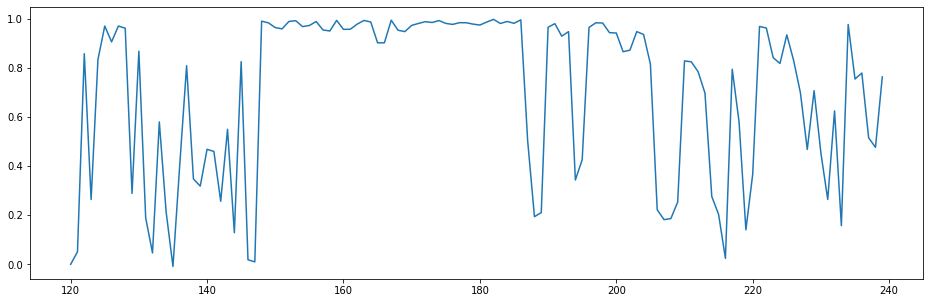

In [55]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [56]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.6777777777777777

In [57]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.6444444444444446

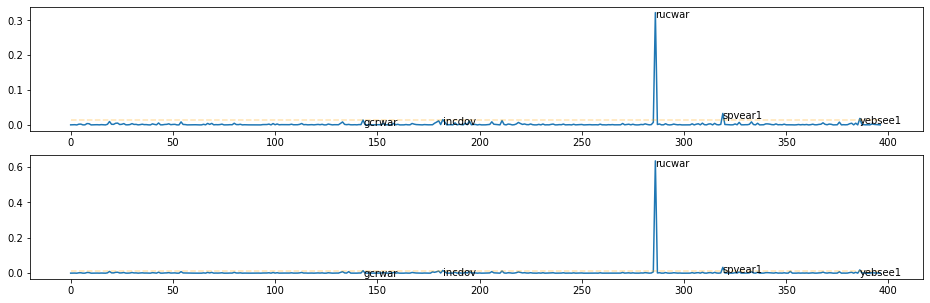

In [58]:
plot_oof_mean(df)

## audio_id: 20152

In [59]:
idx = valid_df[valid_df["audio_id"] == 20152].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

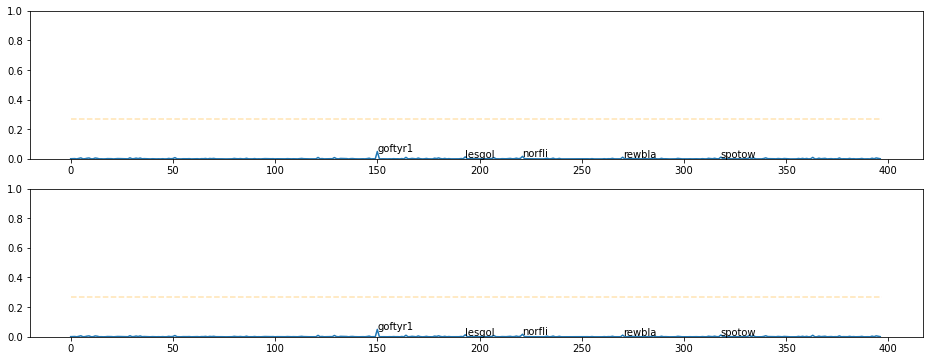

In [60]:
plot_oof(1427)

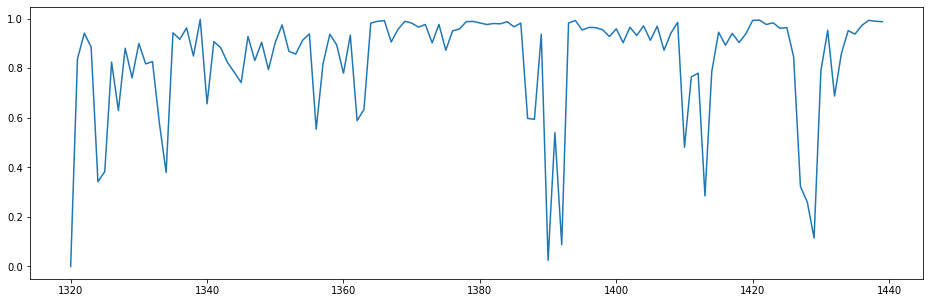

In [61]:
plt.figure(figsize=(16, 5))
plt.plot(df["corr"])

In [62]:
len(df[df["birds"] == "nocall"])

116

In [63]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.9416666666666658

In [64]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.016666666666666666

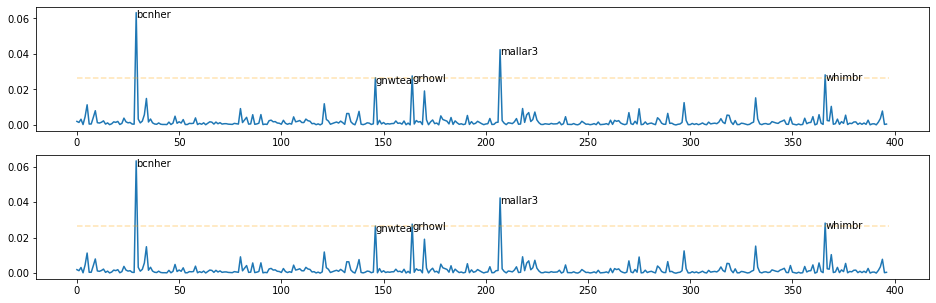

In [65]:
plot_oof_mean(df)

## audio_id: 21767

In [66]:
idx = valid_df[valid_df["audio_id"] == 21767].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

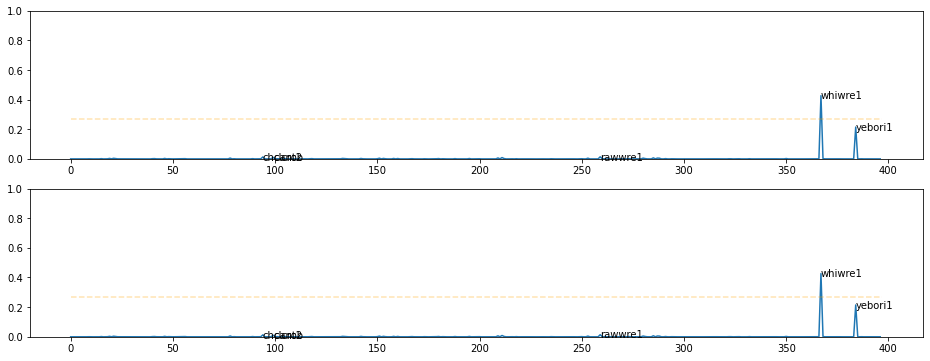

In [132]:
plot_oof(350)

In [130]:
len(df[df["birds"] == "nocall"])

93

In [69]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["oof_birds"])

0.3250000000000001

In [70]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.3180555555555556

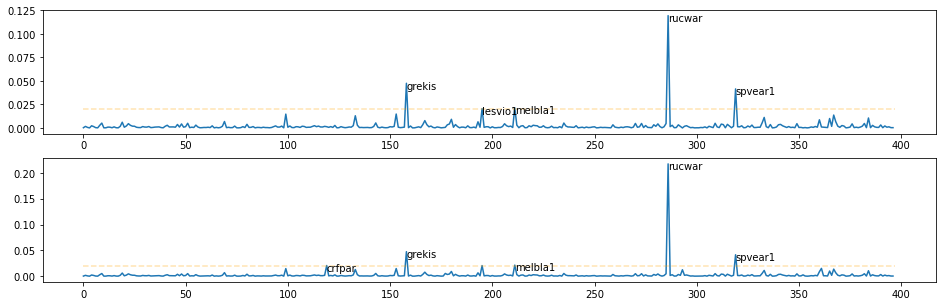

In [71]:
plot_oof_mean(df)

## audio_id: 26709

In [72]:
idx = valid_df[valid_df["audio_id"] == 26709].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

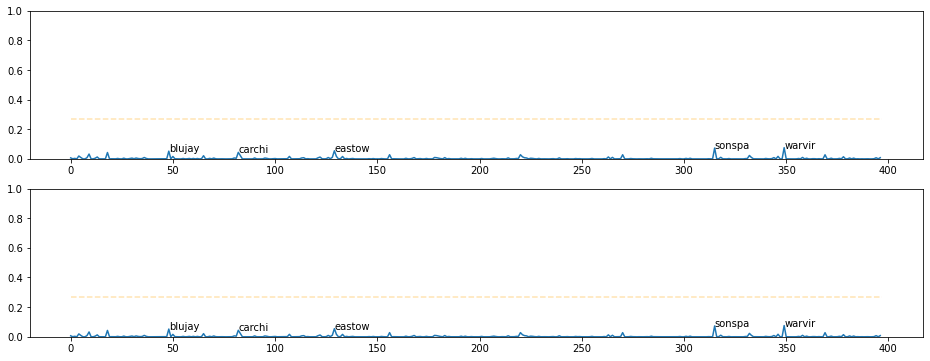

In [143]:
plot_oof(1492)

In [74]:
np.max(oof[1514, :])

0.21337669864296913

In [75]:
len(df[df["birds"] == "nocall"])

62

In [76]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.13888888888888887

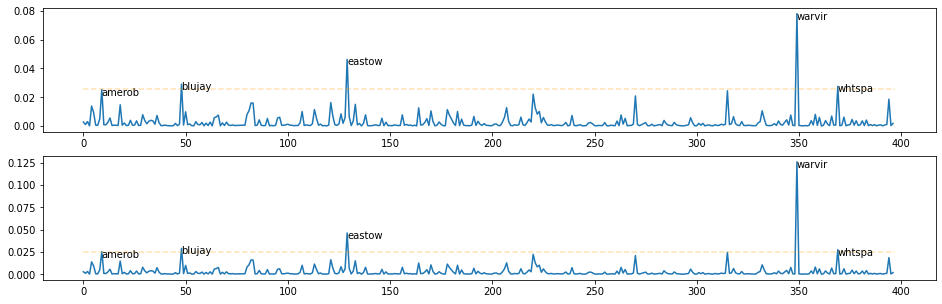

In [77]:
plot_oof_mean(df)

## audio_id: 26746

In [78]:
idx = valid_df[valid_df["audio_id"] == 26746].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

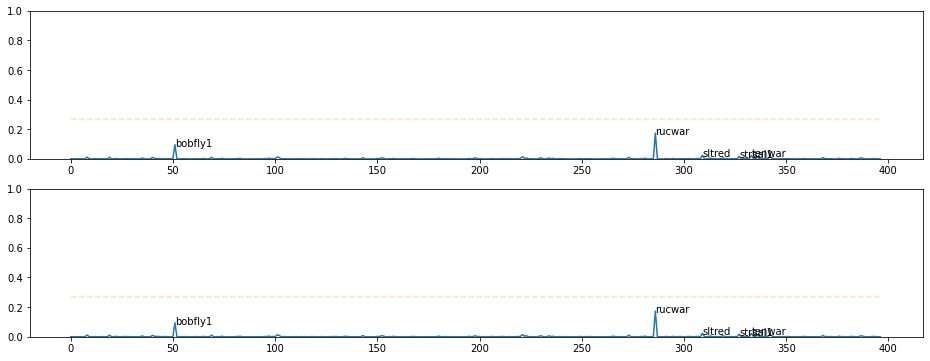

In [139]:
plot_oof(386)

In [80]:
len(df[df["birds"] == "nocall"])

71

In [81]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.20833333333333331

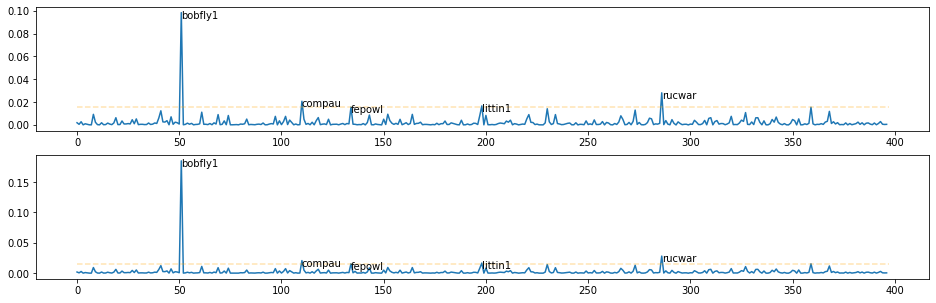

In [82]:
plot_oof_mean(df)

## audio_id: 28933

In [83]:
idx = valid_df[valid_df["audio_id"] == 28933].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

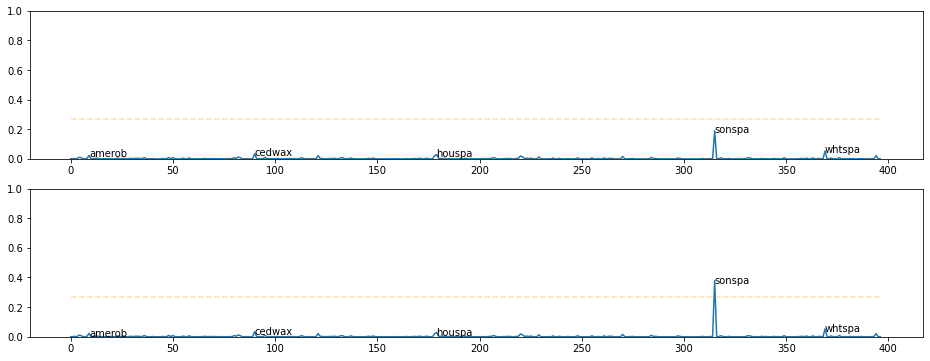

In [142]:
plot_oof(1563)

In [84]:
np.max(oof[1514, :])

0.21337669864296913

In [85]:
len(df[df["birds"] == "nocall"])

18

In [86]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.5699999999999997

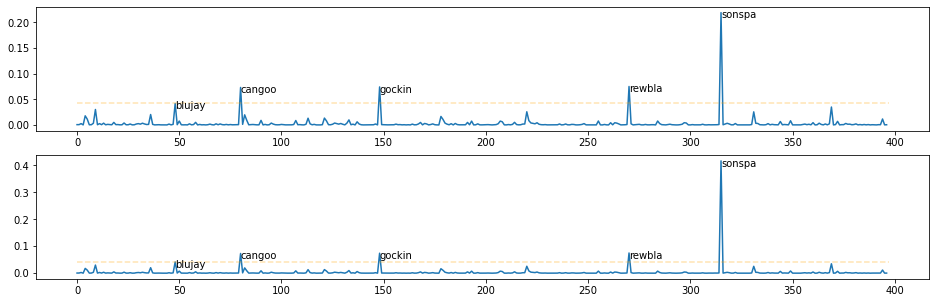

In [87]:
plot_oof_mean(df)

## audio_id: 31928

In [88]:
idx = valid_df[valid_df["audio_id"] == 31928].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

In [89]:
np.max(oof[1514, :])

0.21337669864296913

In [90]:
len(df[df["birds"] == "nocall"])

120

In [91]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.0

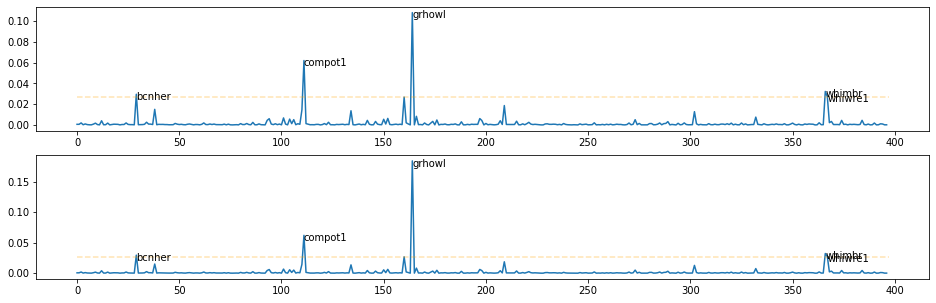

In [92]:
plot_oof_mean(df)

## audio_id: 42907

In [93]:
idx = valid_df[valid_df["audio_id"] == 42907].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

In [94]:
np.max(oof[1514, :])

0.21337669864296913

In [95]:
len(df[df["birds"] == "nocall"])

75

In [96]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.35000000000000026

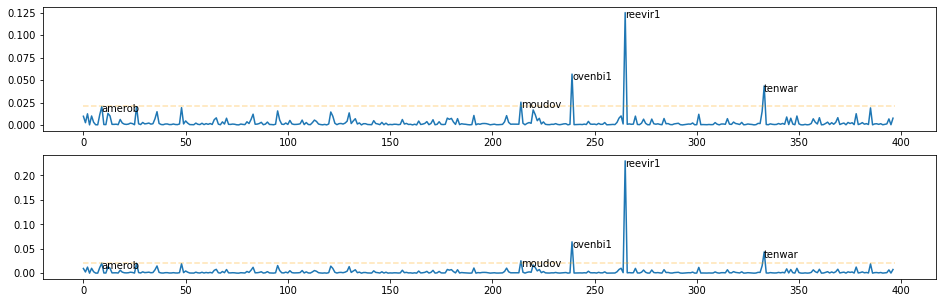

In [97]:
plot_oof_mean(df)

## audio_id: 44957

In [98]:
idx = valid_df[valid_df["audio_id"] == 44957].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

In [99]:
np.max(oof[1514, :])

0.21337669864296913

In [100]:
len(df[df["birds"] == "nocall"])

49

In [101]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.458333333333334

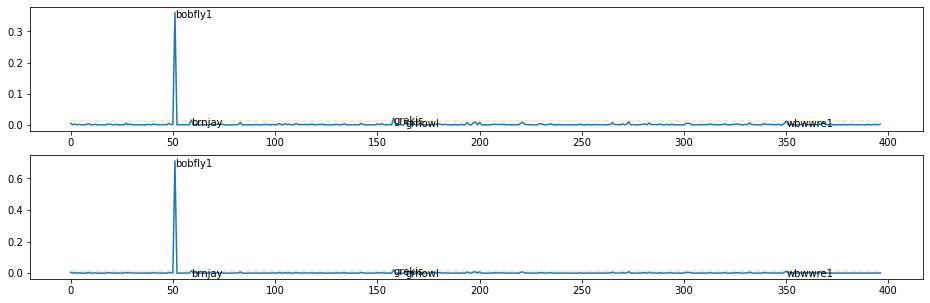

In [102]:
plot_oof_mean(df)

## audio_id: 50878

In [103]:
idx = valid_df[valid_df["audio_id"] == 50878].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

In [104]:
np.max(oof[1514, :])

0.21337669864296913

In [105]:
len(df[df["birds"] == "nocall"])

115

In [106]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.041666666666666664

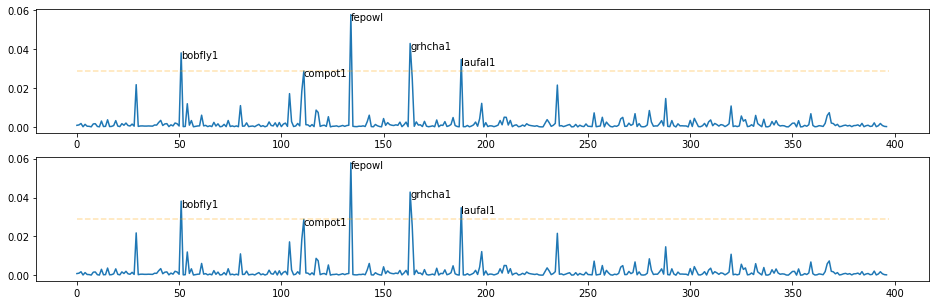

In [107]:
plot_oof_mean(df)

## audio_id: 51010

In [108]:
idx = valid_df[valid_df["audio_id"] == 51010].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

In [109]:
np.max(oof[1514, :])

0.21337669864296913

In [110]:
len(df[df["birds"] == "nocall"])

28

In [111]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.4166666666666667

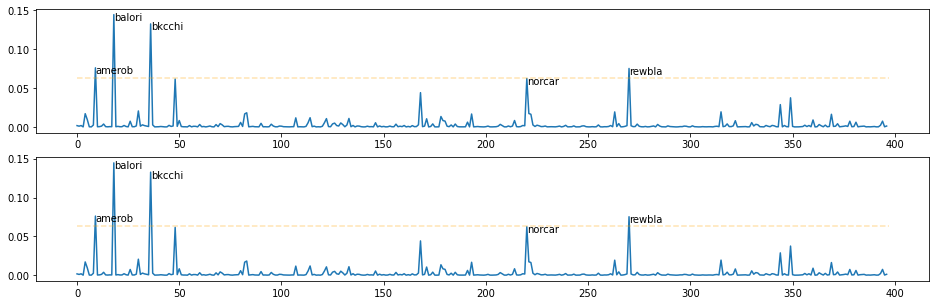

In [112]:
plot_oof_mean(df)

## audio_id: 54955

In [113]:
idx = valid_df[valid_df["audio_id"] == 54955].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

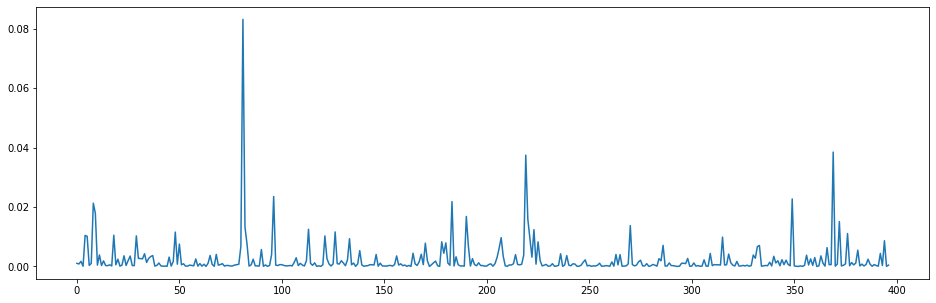

In [114]:
plt.figure(figsize=(16, 5))
plt.plot(oof[2036, :])

In [115]:
len(df[df["birds"] == "nocall"])

100

In [116]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.1222222222222222

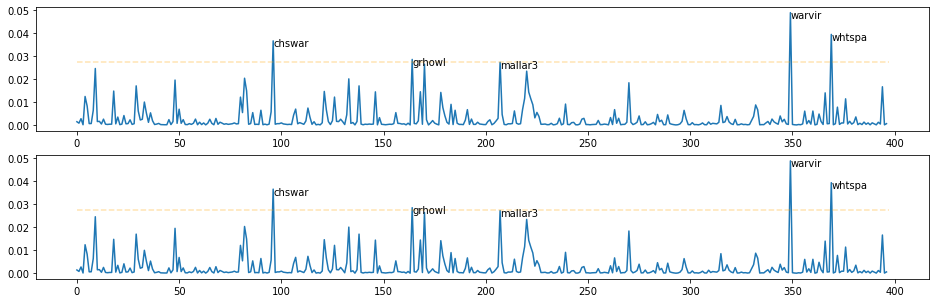

In [117]:
plot_oof_mean(df)

## audio_id: 57610

In [118]:
idx = valid_df[valid_df["audio_id"] == 57610].index.values
df = valid_df.loc[idx]
df[usecols].style.background_gradient(cmap='Reds_r', low=1.0, high=0.0, subset=["f1", "post_f1", "post_post_f1"])

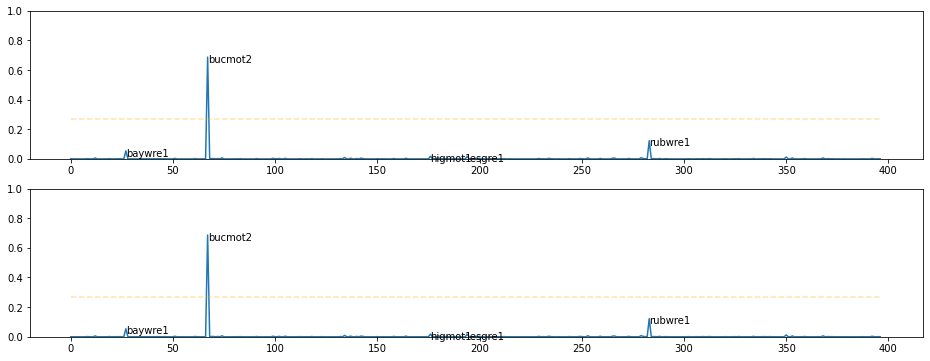

In [119]:
plot_oof(861)

In [120]:
np.max(oof[1514, :])

0.21337669864296913

In [121]:
len(df[df["birds"] == "nocall"])

93

In [122]:
row_wise_micro_averaged_f1_score( df["birds"].values, df["first_label"])

0.18888888888888886

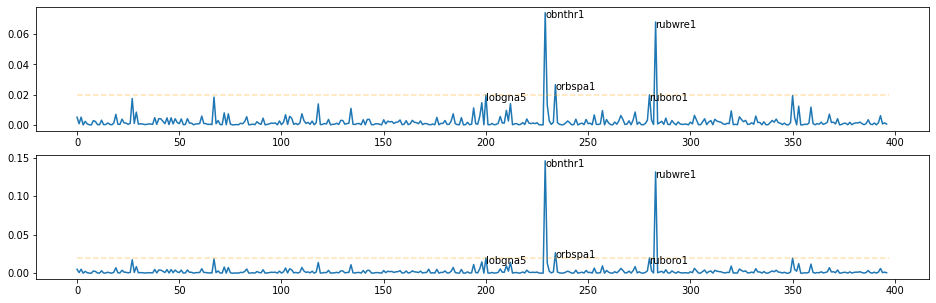

In [123]:
plot_oof_mean(df)

In [124]:
valid_df["div"] = np.max(oof, axis=1) / np.sort(oof, axis=1)[:, -2]

In [125]:
valid_df[valid_df["birds"] == "nocall"].sort_values(by="div").tail(100)

row_id site  audio_id  seconds   birds oof_birds post_raw_birds  \
292   21767_COR_265  COR     21767      265  nocall    nocall         nocall   
1726  42907_SSW_235  SSW     42907      235  nocall    nocall         nocall   
1931   54955_SSW_60  SSW     54955       60  nocall    nocall         nocall   
6      11254_COR_35  COR     11254       35  nocall    nocall         nocall   
431   26746_COR_360  COR     26746      360  nocall    nocall         nocall   
26    11254_COR_135  COR     11254      135  nocall    nocall         nocall   
1841  51010_SSW_210  SSW     51010      210  nocall    warvir         nocall   
299   21767_COR_300  COR     21767      300  nocall    nocall         nocall   
832   50878_COR_565  COR     50878      565  nocall    nocall         nocall   
1753  42907_SSW_370  SSW     42907      370  nocall   reevir1         nocall   
905   57610_COR_330  COR     57610      330  nocall    nocall         nocall   
46    11254_COR_235  COR     11254      235  nocall    yebfly         nocall   
1674  28933_SSW_575  SSW     28933      575  nocall    nocall         nocall   
1896  51010_SSW_485  SSW     51010      485  nocall    amerob         nocall   
1112   7843_SSW_165  SSW      7843      165  nocall    nocall         nocall   
889   57610_COR_250  COR     57610      250  nocall    nocall         nocall   
839   50878_COR_600  COR     50878      600  nocall   compot1        compot1   
1988  54955_SSW_345  SSW     54955      345  nocall    nocall         nocall   
1737  42907_SSW_290  SSW     42907      290  nocall    moudov         nocall   
800   50878_COR_405  COR     50878      405  nocall    fepowl         fepowl   
1780  42907_SSW_505  SSW     42907      505  nocall    nocall         nocall   
1226  10534_SSW_135  SSW     10534      135  nocall    bkcchi         bkcchi   
1375  20152_SSW_280  SSW     20152      280  nocall    bcnher         nocall   
1758  42907_SSW_395  SSW     42907      395  nocall    nocall         nocall   
227   18003_COR_540  COR     18003      540  nocall    incdov         nocall   
703   44957_COR_520  COR     44957      520  nocall    nocall         nocall   
161   18003_COR_210  COR     18003      210  nocall    rucwar         rucwar   
38    11254_COR_195  COR     11254      195  nocall    yebfly         yebfly   
1745  42907_SSW_330  SSW     42907      330  nocall    nocall         nocall   
1286  10534_SSW_435  SSW     10534      435  nocall    rewbla         rewbla   
904   57610_COR_325  COR     57610      325  nocall    nocall         nocall   
757   50878_COR_190  COR     50878      190  nocall    nocall         nocall   
1353  20152_SSW_170  SSW     20152      170  nocall    nocall         nocall   
868   57610_COR_145  COR     57610      145  nocall   lesgre1         nocall   
1471  26709_SSW_160  SSW     26709      160  nocall    nocall         nocall   
101   11254_COR_510  COR     11254      510  nocall    nocall         nocall   
1241  10534_SSW_210  SSW     10534      210  nocall    rewbla         rewbla   
877   57610_COR_190  COR     57610      190  nocall    nocall         nocall   
664   44957_COR_325  COR     44957      325  nocall    nocall         nocall   
430   26746_COR_355  COR     26746      355  nocall    nocall         nocall   
1336   20152_SSW_85  SSW     20152       85  nocall    nocall         nocall   
1310  10534_SSW_555  SSW     10534      555  nocall    rewbla         rewbla   
305   21767_COR_330  COR     21767      330  nocall    nocall         nocall   
1306  10534_SSW_535  SSW     10534      535  nocall    amegfi         nocall   
726    50878_COR_35  COR     50878       35  nocall   grhcha1         nocall   
553   31928_COR_370  COR     31928      370  nocall    nocall         nocall   
829   50878_COR_550  COR     50878      550  nocall    nocall         nocall   
230   18003_COR_555  COR     18003      555  nocall    nocall         nocall   
841    57610_COR_10  COR     57610       10  nocall   orbspa1         nocall   
83    11254_C

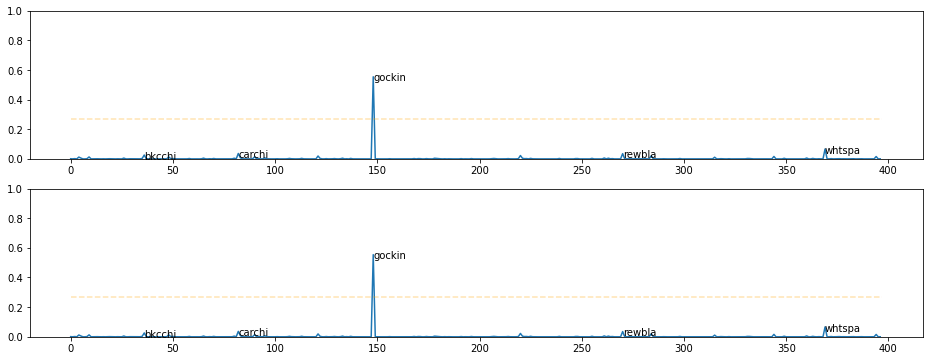

In [126]:
plot_oof(1626)

In [127]:
train_df = pd.read_csv("../data/input/train_metadata.csv")

valid_birds = []
for birds in valid_df["birds"]:
    valid_birds += birds.split(" ")
valid_birds = list(set(valid_birds))

for bird in train_df["primary_label"].unique():
    if bird in valid_birds:
        sample_num = len(train_df[train_df["primary_label"] == bird])
        print(f"【{bird}】   sample:{sample_num}")

        bird_df = valid_df[valid_df["birds"].str.contains(bird)].reset_index(drop=True)
        bird_df["acc"] = True
        true_idx = bird_df[bird_df["oof_birds"] != bird].index
        bird_df.loc[true_idx, "acc"] = False

        print(bird_df["acc"].value_counts().sort_index())
        print("\n" * 3)

【amecro】   sample:229
False    1
Name: acc, dtype: int64




【amegfi】   sample:181
False    5
True     1
Name: acc, dtype: int64




【amerob】   sample:481
False    7
Name: acc, dtype: int64




【balori】   sample:155
False    24
True     16
Name: acc, dtype: int64




【belkin1】   sample:77
False    1
True     2
Name: acc, dtype: int64




【bkcchi】   sample:272
False    39
True     28
Name: acc, dtype: int64




【blujay】   sample:328
False    6
True     6
Name: acc, dtype: int64




【bobfly1】   sample:236
False    26
True     64
Name: acc, dtype: int64




【brnjay】   sample:66
False    5
True     2
Name: acc, dtype: int64




【bucmot2】   sample:38
False    2
True     2
Name: acc, dtype: int64




【cangoo】   sample:265
False    11
True      7
Name: acc, dtype: int64




【chswar】   sample:148
False    12
True      4
Name: acc, dtype: int64




【clcrob】   sample:195
False    3
True     1
Name: acc, dtype: int64




【comgra】   sample:128
False    3
Name: acc, dtype: int64




【comyel】   samp

## 鳥

In [128]:
birds = train_df["primary_label"].unique()

for bird in birds:
    bird_df = valid_df[valid_df["birds"].str.contains(bird)]
    
    if len(bird_df) > 0:
        print(f"TRUE LABEL: {bird}")
        print("-" * 50)
        print(bird_df["post_oof_birds"].value_counts())
        print("\n" * 3)

TRUE LABEL: amecro
--------------------------------------------------
nocall    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: amegfi
--------------------------------------------------
nocall    4
gockin    1
amegfi    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: amerob
--------------------------------------------------
nocall    6
sonspa    1
Name: post_oof_birds, dtype: int64




TRUE LABEL: balori
--------------------------------------------------
balori    17
nocall    14
bkcchi     7
haiwoo     1
rebwoo     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: belkin1
--------------------------------------------------
belkin1    2
rewbla     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: bkcchi
--------------------------------------------------
bkcchi            30
reevir1           23
nocall             6
grycat             4
eawpew             3
reevir1 eawpew     1
Name: post_oof_birds, dtype: int64




TRUE LABEL: blujay
-------------------------------------